# Project: European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Soccer is all about the goals; whichever team scores the most goals wins. [This dataset](https://www.kaggle.com/hugomathien/soccer) contains information about European soccer matches from the years 2008 - 2016. It also contains team and player attributes from the EA FIFA video
game. Although backed up by careful observation and analysis, the FIFA attributes are [in the end more or less arbirtary](https://www.vg247.com/2016/09/27/how-ea-calculates-fifa-17-player-ratings/). I'm more concerned with describing what actually happened, so I will be analyzing match data. I am particulary interested in how the league in each country compares to the others. In order to facilitate this analysis, I will be looking at the goals scored in each league.

### Research Questions

1. Which country's league scored the most goals?
2. How did goal scoring compare across leagues over time?
3. Were more goals scored at home or away?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#missingno for visualizations of missing values
import missingno as msno

#'magic word' so that visualizations are plotted inline with the notebook
%matplotlib inline

# connection to sqlite3 database
db = sqlite3.connect('database.sqlite')

<a id='wrangling'></a>
## Data Wrangling & General Properties

First, let's take a look at what sorts of tables this database contains:

In [2]:
# First, look at tables in the database
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""",db)
display(tables)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


There are tables for player, match, league, country, team, and the FIFA attribues. First, take a look at what kind of information is available in the Country and League tables:

In [3]:
countries = pd.read_sql("""SELECT *
                           FROM Country;""", db)


leagues = pd.read_sql("""SELECT id, name
                     FROM League;""", db)
display(countries)
display(leagues)

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


,id,name
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A
5,13274,Netherlands Eredivisie
6,15722,Poland Ekstraklasa
7,17642,Portugal Liga ZON Sagres
8,19694,Scotland Premier League
9,21518,Spain LIGA BBVA


The tables look almost identical. Each league name also contains the country name and ids are all the same. Now that I have showed the league names, from here on out I will be referencing each league by the country name (for example, 'Spain LIGA BBVA' will be referred to simply as 'Spain'). In order to start analyzing goal-scoring performance across the leagues, let's take a look at the format of the matches table:

In [4]:
matches = pd.read_sql("""SELECT *
                       FROM match;""", db)
display(matches.head())

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


There are 115 columns. That's a lot; let's narrow it down a bit. I'm going to focus on what I understand to be the most generally recognized stats that people look to when comparing how teams fared in their matches. From this table I am going to select the country name, the season, home and away goals, information about the goals, shots on goal, shots off goal, fouls, cards, crosses, corners, and times of possession:

In [5]:
matches_focus = pd.read_sql("""SELECT Country.name AS country_name,
                            season,
                            stage,
                            home.team_long_name AS  home_team,
                            away.team_long_name AS away_team,
                            home_team_goal AS home_goals,
                            away_team_goal AS away_goals,
                            goal,
                            shoton,
                            shotoff,
                            foulcommit,
                            card,
                            cross,
                            corner,
                            possession
                        FROM Match
                        JOIN Country on Country.id = Match.country_id
                        JOIN League on League.id = Match.league_id
                        LEFT JOIN Team AS home on home.team_api_id = Match.home_team_api_id
                        LEFT JOIN Team AS away on away.team_api_id = Match.away_team_api_id
                        ORDER by season;""", db)
display(matches_focus.head())

,country_name,season,stage,home_team,away_team,home_goals,away_goals,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,Belgium,2008/2009,1,KRC Genk,Beerschot AC,1,1,None,None,None,None,None,None,None,None
1,Belgium,2008/2009,1,SV Zulte-Waregem,Sporting Lokeren,0,0,None,None,None,None,None,None,None,None
2,Belgium,2008/2009,1,KSV Cercle Brugge,RSC Anderlecht,0,3,None,None,None,None,None,None,None,None
3,Belgium,2008/2009,1,KAA Gent,RAEC Mons,5,0,None,None,None,None,None,None,None,None
4,Belgium,2008/2009,1,FCV Dender EH,Standard de Liège,1,3,None,None,None,None,None,None,None,None


These numbers will give us a better picture of how each match played out, but even in the head, we already have some missing values. I'm going to use a package called [missingno](https://github.com/ResidentMario/missingno) to visualize the missing values. The black portions of the chart show where we have values, white signifies missing data:

<AxesSubplot:>

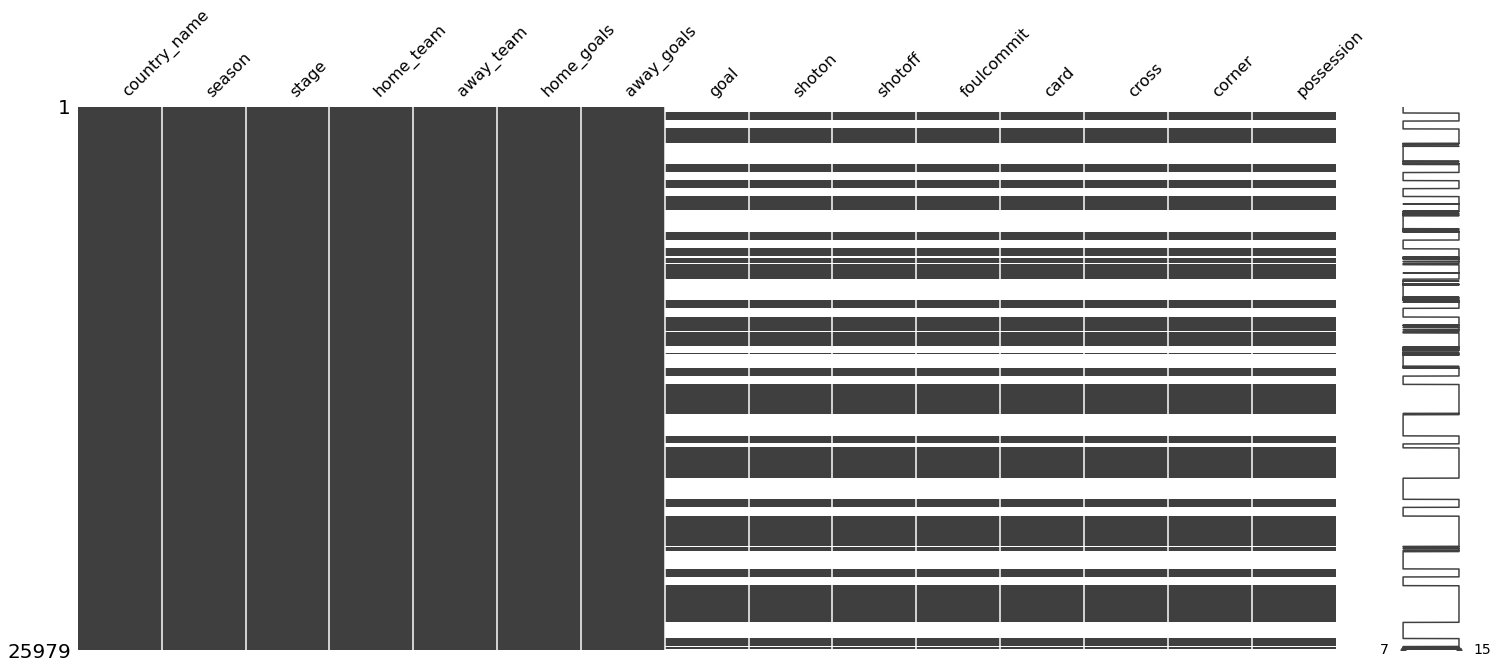

In [6]:
msno.matrix(matches_focus)

It looks like we are missing quite a bit of information from the right-hand portion of the table. At the same time, we are not missing any values for the country_name, season, stage, home_team, away_team, home_goals, and away_goals fields. Let's focus on that part of the table.

### Data Cleaning

First, I will focus the SQL query to only pull the data that is completely filled in. In order to keep things more interesting, I am going to pick out the five most popular leagues. I will justify my choice of Spain, England, Italy, Germany and France by pointing towards the the [UEFA rankings for teams](https://www.uefa.com/memberassociations/uefarankings/country/).

In [7]:
goals_by_season = pd.read_sql("""SELECT Country.name AS country_name,  
                                        season,
                                        count(distinct stage) AS games,
                                        count(distinct home.team_long_name) AS teams,
                                        sum(home_team_goal) AS home_goals,
                                        sum(away_team_goal) AS away_goals,
                                        sum(home_team_goal+away_team_goal) AS total_goals,
                                        avg(home_team_goal) AS avg_home_goals, 
                                        avg(away_team_goal) AS avg_away_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS home on home.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS away on away.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'England', 'Italy', 'Germany', 'France')
                                GROUP BY Country.name, League.name, season
                                ORDER BY Country.name, League.name, season DESC;""", db)
display(goals_by_season)

,country_name,season,games,teams,home_goals,away_goals,total_goals,avg_home_goals,avg_away_goals,avg_goal_dif,avg_goals
0,England,2015/2016,38,20,567,459,1026,1.492105,1.207895,0.284211,2.700000
1,England,2014/2015,38,20,560,415,975,1.473684,1.092105,0.381579,2.565789
2,England,2013/2014,38,20,598,454,1052,1.573684,1.194737,0.378947,2.768421
3,England,2012/2013,38,20,592,471,1063,1.557895,1.239474,0.318421,2.797368
4,England,2011/2012,38,20,604,462,1066,1.589474,1.215789,0.373684,2.805263
5,England,2010/2011,38,20,617,446,1063,1.623684,1.173684,0.450000,2.797368
6,England,2009/2010,38,20,645,408,1053,1.697368,1.073684,0.623684,2.771053
7,England,2008/2009,38,20,532,410,942,1.400000,1.078947,0.321053,2.478947
8,France,2015/2016,38,20,546,414,960,1.436842,1.089474,0.347368,2.526316
9,France,2014/2015,38,20,536,411,947,1.410526,1.081579,0.328947,2.492105


Here, we can see all of the available statistics regarding goals for these five leagues. The SQL query above does a pretty good job of pulling clean data from the database, but let's check some things anyway.

I'll check the shape to make sure we are seeing all rows and all columns:

In [8]:
# shape (rows, columns)
print("Shape: ", goals_by_season.shape)

Shape:  (40, 11)


Indeed, we are seeing all rows and all columns.

Now, we should also check datatypes and double-check for null values (in case you don't believe the missingno visualization):

<AxesSubplot:>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    40 non-null     object 
 1   season          40 non-null     object 
 2   games           40 non-null     int64  
 3   teams           40 non-null     int64  
 4   home_goals      40 non-null     int64  
 5   away_goals      40 non-null     int64  
 6   total_goals     40 non-null     int64  
 7   avg_home_goals  40 non-null     float64
 8   avg_away_goals  40 non-null     float64
 9   avg_goal_dif    40 non-null     float64
 10  avg_goals       40 non-null     float64
dtypes: float64(4), int64(5), object(2)
memory usage: 3.6+ KB


None

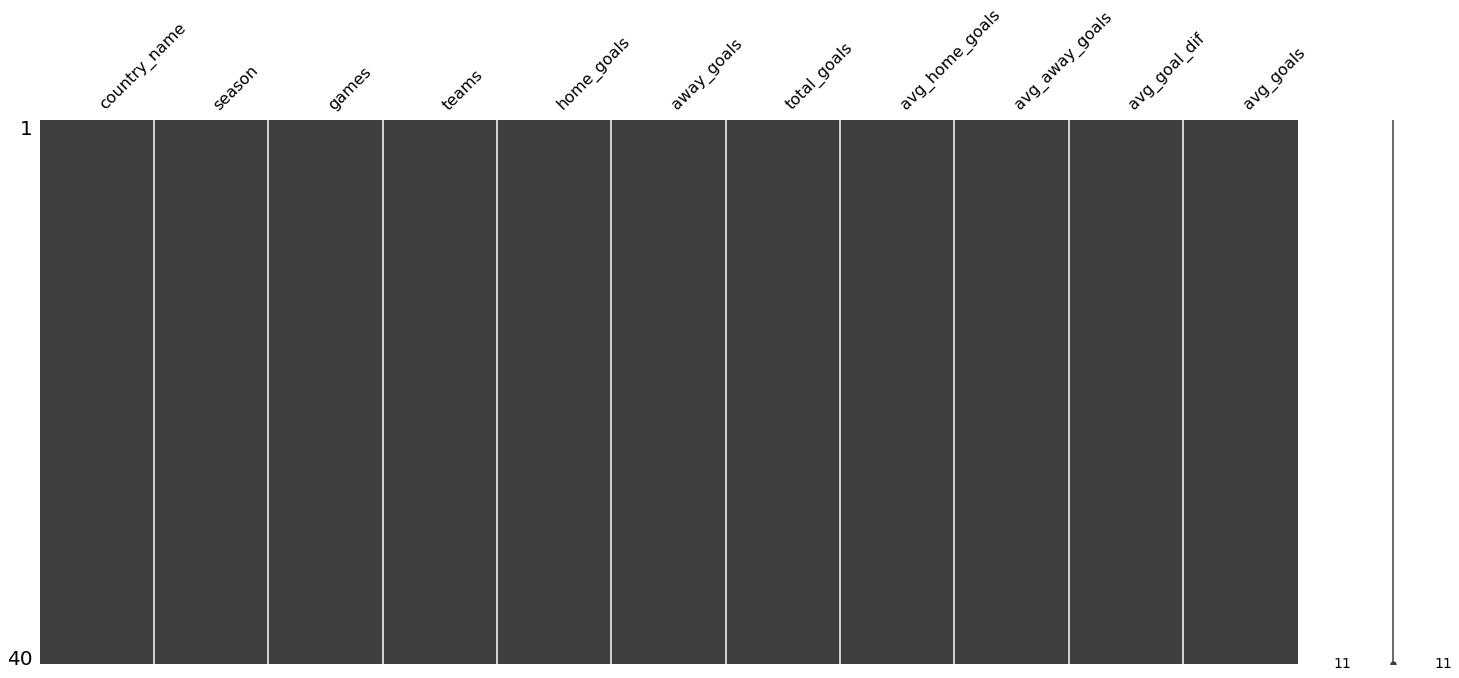

In [9]:
# info
display(msno.matrix(goals_by_season))
display(goals_by_season.info())


There are no null values and the data-types look correct.

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: Total Goals

The data I have selected all pertains to goals scored. Here, I pull the data from the dataframe above in order to look at goals scored in each league by season.

,England,France,Germany,Italy,Spain
2008/2009,1026,960,866,979,1043
2009/2010,975,947,843,1018,1009
2010/2011,1052,933,967,1035,1045
2011/2012,1063,967,898,1003,1091
2012/2013,1066,956,875,925,1050
2013/2014,1063,890,894,955,1042
2014/2015,1053,916,866,992,1031
2015/2016,942,858,894,988,1101


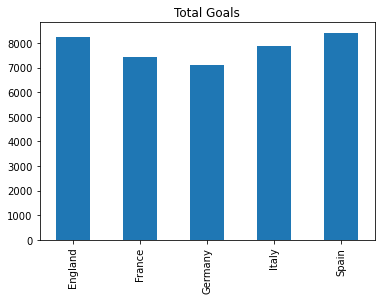

In [10]:
# set up empty dataframe
df_total = pd.DataFrame(index=np.sort(goals_by_season['season'].unique()), columns=goals_by_season['country_name'].unique())
# add values by country
df_total.loc[:,'England'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','total_goals'])
df_total.loc[:,'France'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','total_goals'])
df_total.loc[:,'Germany'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','total_goals'])
df_total.loc[:,'Italy'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','total_goals'])
df_total.loc[:,'Spain'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','total_goals'])

# display dataframe
display(df_total)
# plot totals
display(plot = df_total.sum().plot(kind="bar",title="Total Goals"))

This plot shows that the most goals were scored in Spain and England, while the least goals were scored in Germany. However, it should also be noted that the German season contained four less games than the other leagues. In order to form a better comparison, let's next take a look at the average goals scored. The dataframe above can also be used to plot the average goals scored over time, so we can see how goal-scoring performance developed across the seasons.

### Research Question 2: Average Goals

Here is the plot for average goals scored over time.

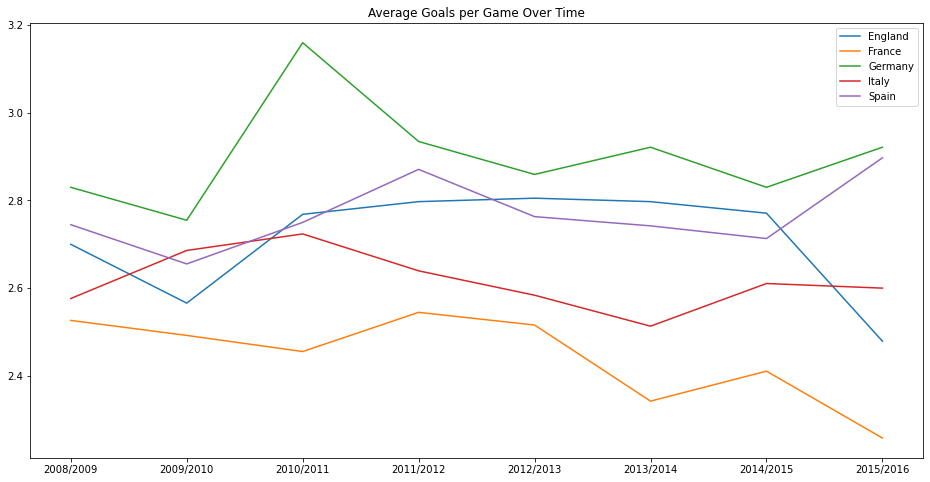

In [11]:
df = pd.DataFrame(index=np.sort(goals_by_season['season'].unique()), columns=goals_by_season['country_name'].unique())

df.loc[:,'Spain'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'England'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','avg_goals'])
df.loc[:,'Italy'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'Germany'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'France'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','avg_goals'])

plot = df.plot(figsize=(16,8), title='Average Goals per Game Over Time')

labels = list(df.index)
plt.show()

Although the least number of total goals were scored in Germany, the German teams actually scored the most goals per game on average per season. This discrepency can be explained by the fact that the German lague plays 34 games per year, while the others play 38.

England, Spain, and Italy fill in the middle (although Italy is generally lower), while France clearly scored the least goals on average over time.

It is also important to notice that, for the most part, average goals per game for all leagues was always between 2 and three goals per game. When watching a soccer game, expect to see 2 or 3 goals.

### Research Question 3:  Home vs. Away Goals

Finally, let's take a look at one of the more interesting trends to emerge from the data. If we compare goals scored at home and goals scored away, it becomes very obvious that soccer teams in Europe score more goals at home. Here is the data and a bar chart:


,spain_home,spain_away,england_home,england_away,italy_home,italy_away,germany_home,germany_away,france_home,france_away
2008/2009,615,428,567,459,559,420,479,387,546,414
2009/2010,584,425,560,415,568,450,486,357,536,411
2010/2011,620,425,598,454,584,451,535,432,538,395
2011/2012,641,450,592,471,568,435,487,411,558,409
2012/2013,638,412,604,462,541,384,508,367,560,396
2013/2014,622,420,617,446,544,411,504,390,510,380
2014/2015,608,423,645,408,586,406,463,403,528,388
2015/2016,631,470,532,410,578,410,520,374,489,369


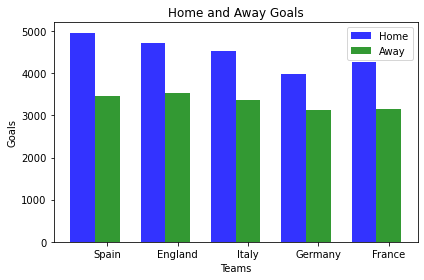

In [12]:
home_and_away = pd.DataFrame(index=np.sort(goals_by_season['season'].unique()),
                             columns=['spain_home','spain_away',
                                      'england_home','england_away',
                                      'italy_home','italy_away',
                                      'germany_home','germany_away',
                                      'france_home','france_away'])

home_and_away.loc[:,'spain_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','home_goals'])
home_and_away.loc[:,'spain_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','away_goals'])
home_and_away.loc[:,'england_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','home_goals'])
home_and_away.loc[:,'england_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','away_goals'])
home_and_away.loc[:,'italy_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','home_goals'])
home_and_away.loc[:,'italy_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','away_goals'])
home_and_away.loc[:,'germany_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','home_goals'])
home_and_away.loc[:,'germany_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','away_goals'])
home_and_away.loc[:,'france_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','home_goals'])
home_and_away.loc[:,'france_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','away_goals'])


display(home_and_away)

# data to plot
n_groups = 5
home_goals = (home_and_away['spain_home'].sum(),home_and_away['england_home'].sum(),home_and_away['italy_home'].sum(),
             home_and_away['germany_home'].sum(),home_and_away['france_home'].sum())
away_goals = (home_and_away['spain_away'].sum(),home_and_away['england_away'].sum(),home_and_away['italy_away'].sum(),
             home_and_away['germany_away'].sum(),home_and_away['france_away'].sum())
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, home_goals, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Home')
 
rects2 = plt.bar(index + bar_width, away_goals, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Away')
 
plt.xlabel('Teams')
plt.ylabel('Goals')
plt.title('Home and Away Goals')
plt.xticks(index + bar_width, ('Spain', 'England', 'Italy', 'Germany','France'))
plt.legend()
 
plt.tight_layout()
plt.show()

We can see that every team scored more goals at home. Furthermore, if we look at these results over time, we can also see that at no point did any team score as many goals away as they did at home.

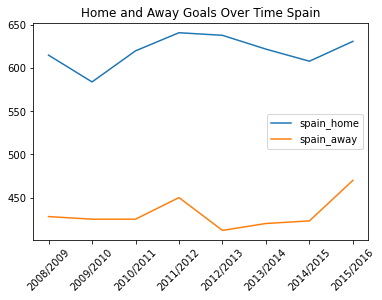

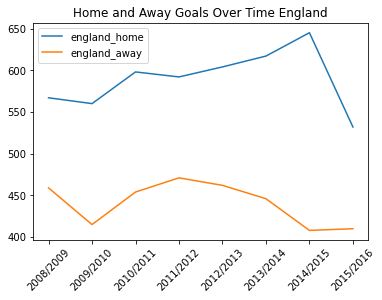

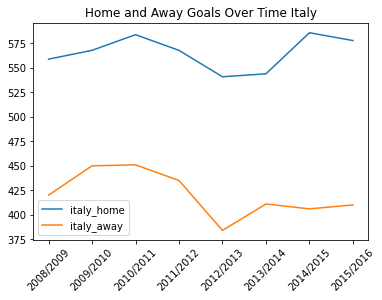

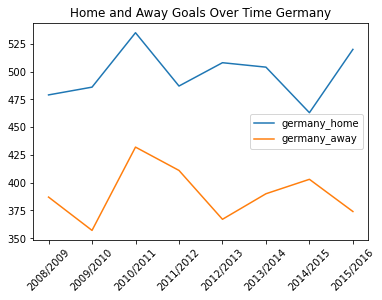

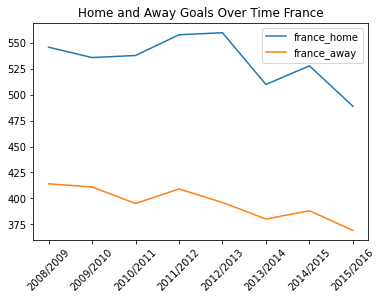

In [13]:
labels = list(home_and_away.index)


esp = home_and_away[['spain_home','spain_away']]
esp_plot = esp.plot(title="Home and Away Goals Over Time Spain")
plt.xticks(rotation = 45)
plt.show();

gba = home_and_away[['england_home','england_away']]
gba_plot = gba.plot(title="Home and Away Goals Over Time England")
plt.xticks(rotation = 45)
plt.show();

itl = home_and_away[['italy_home','italy_away']]
itl_plot = itl.plot(title="Home and Away Goals Over Time Italy")
plt.xticks(rotation = 45)
plt.show();

ale = home_and_away[['germany_home','germany_away']]
ale_plot = ale.plot(title="Home and Away Goals Over Time Germany")
plt.xticks(rotation = 45)
plt.show();

fra = home_and_away[['france_home','france_away']]
fra_plot = fra.plot(title="Home and Away Goals Over Time France")
plt.xticks(rotation = 45)
plt.show();

In [14]:
display(home_and_away)

,spain_home,spain_away,england_home,england_away,italy_home,italy_away,germany_home,germany_away,france_home,france_away
2008/2009,615,428,567,459,559,420,479,387,546,414
2009/2010,584,425,560,415,568,450,486,357,536,411
2010/2011,620,425,598,454,584,451,535,432,538,395
2011/2012,641,450,592,471,568,435,487,411,558,409
2012/2013,638,412,604,462,541,384,508,367,560,396
2013/2014,622,420,617,446,544,411,504,390,510,380
2014/2015,608,423,645,408,586,406,463,403,528,388
2015/2016,631,470,532,410,578,410,520,374,489,369


In [15]:
# average home goals/season
hgs = (home_and_away['spain_home'].sum() + home_and_away['england_home'].sum() + 
 home_and_away['italy_home'].sum() + home_and_away['germany_home'].sum() + 
 home_and_away['france_home'].sum()) / 40

#average away goals/season
ags = (home_and_away['spain_away'].sum() + home_and_away['england_away'].sum() + 
 home_and_away['italy_away'].sum() + home_and_away['germany_away'].sum() + 
 home_and_away['france_away'].sum()) / 40

print(hgs)
print(ags)

561.225
415.7


In [21]:
home_cols = ['spain_home', 'england_home', 'italy_home', 'germany_home', 'france_home']
away_cols = ['spain_away', 'england_away', 'italy_away', 'germany_away', 'france_away']

yearly_totals = pd.DataFrame()
yearly_totals['home'] = home_and_away[home_cols].sum(axis=1)
yearly_totals['away'] = home_and_away[away_cols].sum(axis=1)
display(yearly_totals)

,home,away
2008/2009,2766,2108
2009/2010,2734,2058
2010/2011,2875,2157
2011/2012,2846,2176
2012/2013,2851,2021
2013/2014,2797,2047
2014/2015,2830,2028
2015/2016,2750,2033


In [25]:
# scipy.stats.ttest_rel

from scipy.stats import ttest_rel

ttest_rel(yearly_totals['home'],yearly_totals['away'])

Ttest_relResult(statistic=32.80394281003485, pvalue=6.331864900106364e-09)

<a id='conclusions'></a>
## Conclusions

Overall, this has been a basic analysis of goals scored in European soccer over the years 2008 - 2016. On average, more goals were scored in Germany per season, although they play less games than the other leagues. Most strikingly, teams in every league score more goals at home than they do away. Considering the leagues follow a home and away format (they play every other team twice) this points towards a clear home field advantage in soccer.


### Limitations

There are some limitations to consider regarding this analysis. First of all, apart from goals, many of the values that could have helped compare matches across leagues are missing from the dataset. Furthermore, my SQL skills are somewhat basic, so combining tables to provide further analysis is another limitation of this analysis. For example, more analysis could be done regarding goals scored  at the team or player levels.


